# 1 Data Pre-processing

In [ ]:
# Loading libraries
import json
import pandas as pd
from shapely import MultiLineString, LineString
import kagglehub
import geopandas as gpd
import networkx as nx
from geopy.distance import great_circle
import matplotlib.pyplot as plt
import igraph as ig

,type,properties,geometry
0,Feature,"{'id': 'carnival-submarine-network-1-csn-1', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
1,Feature,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","{'type': 'MultiLineString', 'coordinates': [[[..."
2,Feature,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","{'type': 'MultiLineString', 'coordinates': [[[..."
3,Feature,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","{'type': 'MultiLineString', 'coordinates': [[[..."
4,Feature,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","{'type': 'MultiLineString', 'coordinates': [[[..."
...,...,...,...
505,Feature,"{'id': 'pgascom', 'name': 'PGASCOM', 'color': ...","{'type': 'MultiLineString', 'coordinates': [[[..."
506,Feature,{'id': 'boracay-palawan-submarine-cable-system...,"{'type': 'MultiLineString', 'coordinates': [[[..."
507,Feature,"{'id': 'saudi-arabia-sudan-1-sas-1', 'name': '...","{'type': 'MultiLineString', 'coordinates': [[[..."
508,Feature,"{'id': 'falcon', 'name': 'FALCON', 'color': '#...","{'type': 'MultiLineString', 'coordinates': [[[..."


In [ ]:
# Download latest version
path = kagglehub.dataset_download("sndorburian/underwater-marine-data-cables")
data = json.load(open("../data/kaggle/underwatercable.json"))
df_undersea = pd.DataFrame(data["features"])
df_undersea

In [ ]:
name_list = []
id_list = []
color_list = []

for i in df_undersea.index:
    name_i = df_undersea.loc[i].properties["name"]
    name_list.append(name_i)
    id_i = df_undersea.loc[i].properties["id"]
    id_list.append(id_i)
    color_i = df_undersea.loc[i].properties["color"]
    color_list.append(color_i)

geom_list = []
for i in df_undersea.index:
    geom_i = MultiLineString(pd.DataFrame(data["features"]).geometry.loc[i]["coordinates"])
    geom_list.append(geom_i)

gdf_undersea = df_undersea.copy(deep=False)
gdf_undersea = gpd.GeoDataFrame(gdf_undersea, geometry = geom_list)
gdf_undersea = gdf_undersea.set_crs(4326)

gdf_undersea["id"] = id_list
gdf_undersea["name"] = name_list
gdf_undersea["color"] = color_list

gdf_undersea

,type,properties,geometry,id,name,color
0,Feature,"{'id': 'carnival-submarine-network-1-csn-1', '...","MULTILINESTRING ((-79.53671 8.96483, -79.42487...",carnival-submarine-network-1-csn-1,Carnival Submarine Network-1 (CSN-1),#939597
1,Feature,"{'id': 'sea-h2x', 'name': 'SEA-H2X', 'color': ...","MULTILINESTRING ((113.84999 17.10852, 116.9999...",sea-h2x,SEA-H2X,#939597
2,Feature,"{'id': 'hronn', 'name': 'Hronn', 'color': '#00...","MULTILINESTRING ((5.40007 55.3559, 5.28757 55....",hronn,Hronn,#009f94
3,Feature,"{'id': 'cook-strait', 'name': 'Cook Strait', '...","MULTILINESTRING ((174.23597 -41.33903, 174.431...",cook-strait,Cook Strait,#951f63
4,Feature,"{'id': 'minoas-east-and-west', 'name': 'Minoas...","MULTILINESTRING ((23.03575 36.52322, 23.28756 ...",minoas-east-and-west,Minoas East and West,#939597
...,...,...,...,...,...,...
505,Feature,"{'id': 'pgascom', 'name': 'PGASCOM', 'color': ...","MULTILINESTRING ((103.70596 1.25931, 103.86558...",pgascom,PGASCOM,#7c9e3e
506,Feature,{'id': 'boracay-palawan-submarine-cable-system...,"MULTILINESTRING ((120.20077 12.00543, 120.3749...",boracay-palawan-submarine-cable-system,Boracay-Palawan Submarine Cable System,#2b51a3
507,Feature,"{'id': 'saudi-arabia-sudan-1-sas-1', 'name': '...","MULTILINESTRING ((37.21968 19.61557, 37.58924 ...",saudi-arabia-sudan-1-sas-1,Saudi Arabia-Sudan-1 (SAS-1),#68bc45
508,Feature,"{'id': 'falcon', 'name': 'FALCON', 'color': '#...","MULTILINESTRING ((43.00854 14.68566, 42.75004 ...",falcon,FALCON,#c62026


In [3]:
gdf_undersea.explore()

# 2 Graph Network

## 2.1 Graph Creation & Analysis

In [5]:
# Setting up an empty graph
G = nx.Graph()

In [6]:
# Reading in the GeoJSON files of the edges and nodes as GeoPandas
gdf_nodes_json = gpd.read_file('../data/gdf_nodes.geojson')
gdf_edges_json = gpd.read_file('../data/gdf_edges.geojson')

In [7]:
gdf_nodes_json

,node_id,cable_id,geometry
0,node_0000,carnival-submarine-network-1-csn-1,POINT (-79.53671 8.96483)
1,node_0001,carnival-submarine-network-1-csn-1,POINT (-79.42487 8.19054)
2,node_0002,carnival-submarine-network-1-csn-1,POINT (-78.97487 7.29876)
3,node_0003,carnival-submarine-network-1-csn-1,POINT (-79.19987 5.06199)
4,node_0004,carnival-submarine-network-1-csn-1,POINT (-81.44987 2.36791)
...,...,...,...
9399,node_9399,seamewe-3,POINT (66.37503 23.2986)
9400,node_9400,seamewe-3,POINT (114.29999 22.05299)
9401,node_9401,seamewe-3,POINT (115.64999 22.10511)
9402,node_9402,seamewe-3,POINT (117.44999 21.94868)


In [8]:
gdf_edges_json

,edge_id,cable_id,start_node,end_node,weight,geometry
0,edge_0000,carnival-submarine-network-1-csn-1,node_0000,node_0001,88.053051,"LINESTRING (-79.53671 8.96483, -79.42487 8.19054)"
1,edge_0001,carnival-submarine-network-1-csn-1,node_0001,node_0002,112.012998,"LINESTRING (-79.42487 8.19054, -78.97487 7.29876)"
2,edge_0002,carnival-submarine-network-1-csn-1,node_0002,node_0003,251.717905,"LINESTRING (-78.97487 7.29876, -79.19987 5.06199)"
3,edge_0003,carnival-submarine-network-1-csn-1,node_0003,node_0004,391.244580,"LINESTRING (-79.19987 5.06199, -81.44987 2.36791)"
4,edge_0004,carnival-submarine-network-1-csn-1,node_0004,node_0005,224.025995,"LINESTRING (-81.44987 2.36791, -82.34987 0.56858)"
...,...,...,...,...,...,...
9742,edge_9742,seamewe-3,node_9400,node_9401,150.411602,"LINESTRING (114.29999 22.05299, 115.64999 22.1..."
9743,edge_9743,seamewe-3,node_9401,node_9402,201.253569,"LINESTRING (115.64999 22.10511, 117.44999 21.9..."
9744,edge_9744,seamewe-3,node_9402,node_9387,107.000266,"LINESTRING (117.44999 21.94868, 118.34999 22.2..."
9745,edge_9745,seamewe-3,node_9382,node_9403,112.012998,"LINESTRING (105.3 2.81745, 104.4 2.36791)"


In [9]:
# Creating graph G in NetworkX from the Geo DFs
G = nx.from_pandas_edgelist(
    gdf_edges_json,
    source='start_node',
    target='end_node',
    edge_attr='weight'
)

node_positions = {
    row['node_id']: (row.geometry.x, row.geometry.y)
    for index, row in gdf_nodes_json.iterrows()
}
nx.set_node_attributes(G, node_positions, name='pos')

In [10]:
# Observing total number of edges and vertices in our graph
print(f"Number of Edges: {G.number_of_edges()}\nNumber of Vertices: {G.number_of_nodes()}")

Number of Edges: 9736
Number of Vertices: 9404


# 2.2 Visualizing the Graph

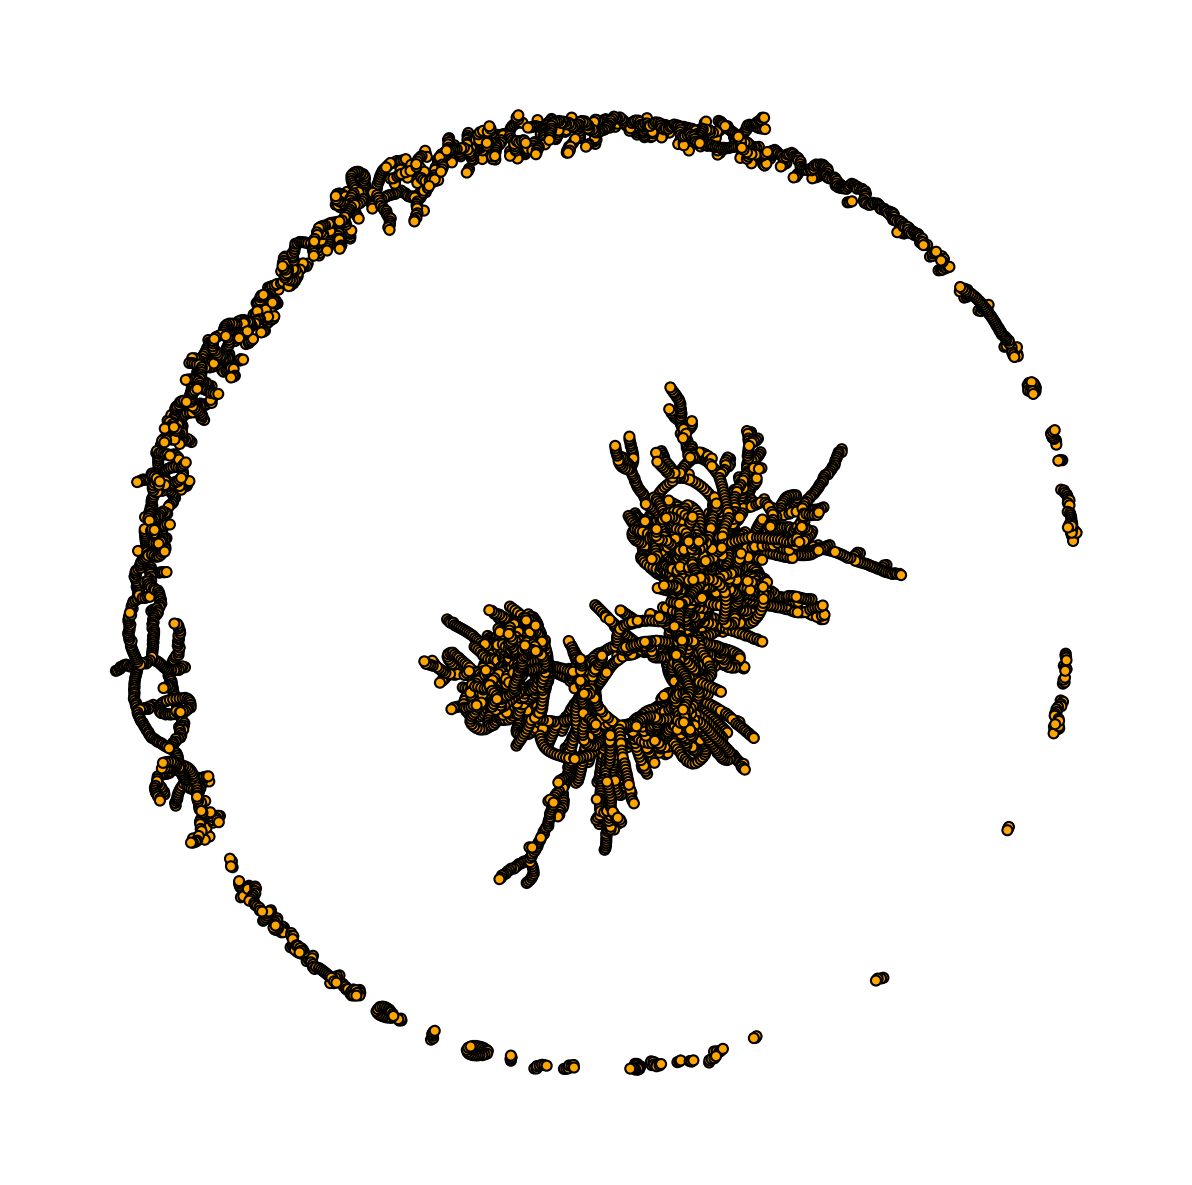

In [ ]:
# Converting our NetworkX graph into an igraph so we can visualize it using Matplotlib
ig_graph = ig.Graph.from_networkx(G)

# Defining a dictionary for visual styles
visual_style = {
    "vertex_size": 10,
    "vertex_color": "orange",
    "vertex_label": None,
    "edge_width": 5,
    "edge_color": "#444444",
    "layout": "kamada_kawai",
}

# Creating a Matplotlib figure and axes
fig, ax = plt.subplots(figsize=(5, 5), dpi=150)

# Plotting the graph using igraph, but targeting the Matplotlib axes
ig.plot(
    ig_graph,
    target=ax,
    **visual_style
)

# Customizing and show the plot using Matplotlib commands
plt.axis('off')
plt.show()


## 2.3 Shortest Path with Djikstra

In [12]:
# Assigning coordinates for our cities & countries of interest
PORTUGAL_COORDS = (38.736946, -9.142685)  # (lat, lon) for Lisbon, Portugal
BRAZIL_COORDS = (-3.731862, -38.526669)   # (lat, lon) for Fortaleza, Brazil 

In [13]:
# Defining the function to find closest cable node to our cities of interest
def find_closest_node(graph, target_coords):

    target_lat, target_lon = target_coords
    closest_node_id = None
    min_dist = float('inf')

    # We iterate through all nodes and their data (attributes)
    for node_id, attributes in graph.nodes(data=True):
        node_lon, node_lat = attributes['pos']
        
        dist = great_circle((target_lat, target_lon), (node_lat, node_lon)).kilometers
        
        if dist < min_dist:
            min_dist = dist
            closest_node_id = node_id
            
    print(f"Found closest node for target {target_coords}: '{closest_node_id}' (Distance: {min_dist:.2f} km)")
    return closest_node_id

In [14]:
# Defining the function for the Djikstra algorithm
def djikstra_sp(graph, source, target):
    
    # Calculating the shortest path using Djikstra algorithm
    path_length = nx.dijkstra_path_length(
        graph, source=source, target=target, weight='weight')

    # Get the actual sequence of nodes in the path
    path_nodes = nx.dijkstra_path(
        graph, source=source, target=target, weight='weight')

    print(f"Total distance: {path_length:,.2f} km")
    print(f"Path involves {len(path_nodes)} nodes.")
    return path_nodes

In [15]:
# Identifying start (Portugal) and end (Brazil) nodes in the graph
start_node = find_closest_node(G, PORTUGAL_COORDS)
end_node = find_closest_node(G, BRAZIL_COORDS)

Found closest node for target (38.736946, -9.142685): 'node_0310' (Distance: 1.41 km)
Found closest node for target (-3.731862, -38.526669): 'node_3704' (Distance: 2.32 km)


In [16]:
shortest_path_nodes = djikstra_sp(G, start_node, end_node)
shortest_path_nodes

Total distance: 6,410.00 km
Path involves 26 nodes.


['node_0310',
 'node_0307',
 'node_0308',
 'node_0309',
 'node_3740',
 'node_3739',
 'node_3738',
 'node_3737',
 'node_3736',
 'node_3735',
 'node_3734',
 'node_3733',
 'node_3732',
 'node_3731',
 'node_3730',
 'node_3729',
 'node_3728',
 'node_3727',
 'node_3726',
 'node_3725',
 'node_3724',
 'node_3723',
 'node_3722',
 'node_3721',
 'node_3720',
 'node_3704']

In [17]:
# Matching shortest path nodes to the additional data in the initial nodes DF
path_nodes_gdf = gdf_nodes_json.set_index('node_id').loc[shortest_path_nodes]

# Creating the path line
path_line = LineString(path_nodes_gdf.geometry)
path_line_gdf = gpd.GeoDataFrame(geometry=[path_line], crs="EPSG:4326")
m = path_line_gdf.explore(
    color="blue",
    style_kwds={'weight': 3},
    name="Shortest Path Line"
)

# Representing the individual path nodes
path_nodes_gdf.explore(
    m=m,
    marker_type='circle_marker',
    marker_kwds={'radius': 4, 'fill': True, 'color': 'green'},
    tooltip=['node_id', 'cable_id'],
    name="Path Nodes"
)

## 2.4 Second Shortest Path

In [18]:
# Now, assuming the scenario that the shortest path undersea cable is destroyed, 
# what is the next shortest path / route from Portugal to Brazil?
G_copy = G.copy()
G_copy.remove_nodes_from(shortest_path_nodes)
G_copy.number_of_nodes()

9378

In [19]:
start_node = find_closest_node(G_copy, PORTUGAL_COORDS)
end_node = find_closest_node(G_copy, BRAZIL_COORDS)

Found closest node for target (38.736946, -9.142685): 'node_1907' (Distance: 1.42 km)
Found closest node for target (-3.731862, -38.526669): 'node_3687' (Distance: 2.32 km)


In [20]:
shortest_path_nodes = djikstra_sp(G_copy, start_node, end_node)
shortest_path_nodes

Total distance: 14,349.21 km
Path involves 35 nodes.


['node_1907',
 'node_1906',
 'node_1905',
 'node_1904',
 'node_1903',
 'node_1902',
 'node_1901',
 'node_1900',
 'node_1899',
 'node_1898',
 'node_1897',
 'node_1896',
 'node_1895',
 'node_1894',
 'node_1893',
 'node_1872',
 'node_1878',
 'node_1879',
 'node_1576',
 'node_3750',
 'node_3751',
 'node_3752',
 'node_3753',
 'node_3754',
 'node_3697',
 'node_3696',
 'node_3695',
 'node_3694',
 'node_3693',
 'node_3692',
 'node_3691',
 'node_3690',
 'node_3689',
 'node_3688',
 'node_3687']

In [21]:
# Matching shortest path nodes to the additional data in the initial nodes DF
path_nodes_gdf = gdf_nodes_json.set_index('node_id').loc[shortest_path_nodes]

# Creating the path line
path_line = LineString(path_nodes_gdf.geometry)
path_line_gdf = gpd.GeoDataFrame(geometry=[path_line], crs="EPSG:4326")
m = path_line_gdf.explore(
    color="blue",
    style_kwds={'weight': 3},
    name="Shortest Path Line"
)

# Representing the individual path nodes
path_nodes_gdf.explore(
    m=m,
    marker_type='circle_marker',
    marker_kwds={'radius': 4, 'fill': True, 'color': 'green'},
    tooltip=['node_id', 'cable_id'],
    name="Path Nodes"
)